In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:40809 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

13.250778913497925


# Prepare data for processing

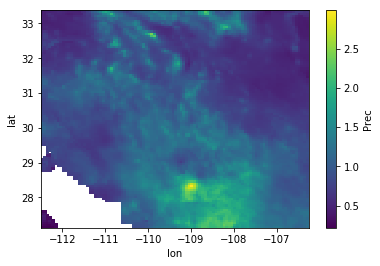

In [4]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(200,300), lon=slice(200,300), time=slice(0,200))
ds2.Prec.mean('time').plot()

# The following is one level of MRA Cluster:

# Compute DWT

In [47]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(ds2.Prec.data.shape)
levels = 1
wave = 'haar'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 
max_level

6

In [48]:
#Compute the DWT

wp = pywt.wavedecn(data=ds2.Prec.data, wavelet=wave, level = min(levels,max_level))

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


# Cluster data at chosen level using DBScan

In [49]:
#Reshape the data
shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
shaped = np.transpose(shaped)
shaped.shape

(2500, 100)

In [50]:
#Remove nan values to cluster.  MAKE INTO FUNCTION
data = []
index = []
index_nan = []
count = 0
for p in range(shaped.shape[0]):
    if np.isnan(shaped[p][0]):  #check if nan
        index_nan.append(count)
        count = count +1
    else:
        data.append(shaped[p])
        index.append(count)
        count = count + 1       

In [51]:
%time
data = da.stack(data, axis=0)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


In [52]:
data.shape

(2350, 100)

In [53]:
#Discover the epsilon for DBScan using knn.  May want to alter the metric.  
# THIS SEEMS SLOW, SPEED UP
%time
nbrs = NearestNeighbors(3, algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)

#Set the distance to use as within 98th percentile:
epsilon = np.percentile(distances[:,[1,-1]], 98)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [54]:
#connection = nbrs.radius_neighbors_graph(shaped, radius = epsilon).toarray()
#connection = np.sum(connection, axis=1)
#np.histogram(connection, bins = 72)

In [55]:
#Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
# at least 2).

ratio_dwt = 0.001

min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
min_size

3.0

In [64]:
#Perform db scan and return the result
%time
classes = DBSCAN(eps=epsilon, min_samples=min_size).fit_predict(data)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [68]:
np.histogram(classes, bins=8)

(array([  36,    7, 2262,    4,   15,    4,    4,   18]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]))

In [76]:
a = np.array([3,1,2,0,4])
b = np.array([6,7,7,1,2])
b[a]

array([1, 7, 7, 6, 2])

In [61]:
#Thread the NAN values back in with classes:

#MAKE A FUNCTION

#Build the nan array
classes_nan = np.ones(len(index_nan))*np.nan
classes = np.append(classes, classes_nan)


index_all = index + index_nan
index_all = np.array(index_all)

classes = classes[index_all]

In [63]:
np.histogram(classes, bins = 2)

/home/ddesantis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/ddesantis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: range parameter must be finite.

In [58]:
#Reshape classes to match back up with original
classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))

In [59]:
classes.shape

(50, 50)

In [46]:
classes

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
#Plot histogram of values:


# Map classes back to (lat,lon) points

In [62]:
#In general, the inverse map will depend on the choice of wavelet.
#For now, we only use the Haar wavelet
#Also, only works for origoinal data selected to have even size (odd size need to adjust)

In [63]:
classes.shape

(25, 25)

In [64]:
#Create index matricies to inflate data back to same size:
for j in range(min(levels,max_level)):
    L = np.kron(np.eye(classes.shape[0]), np.array([[1],[1]]))
    R = np.kron(np.eye(classes.shape[1]), np.array([[1, 1]]))
    classes = np.matmul(np.matmul(L, classes),R)

In [65]:
classes.shape

(200, 200)

# Discover Final Classes

In [61]:
# For each resolution, we get a classes array. The class label is a vector (l_1, ... l_K), where K is the number of 
# levels computed. 

In [32]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [22]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[index_all]
    
    return classes

In [37]:
#Function to compute single level for feature data
def single_level_class(data_set, feature, level, wavelet='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    #Compute DWT
    wp = pywt.wavedecn(data=data_set[feature].data, wavelet=wave, level = min(levels,max_level))
    
    #Reshape the data for DBScan
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    #Discover the epsilon for DBScan using knn. 
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)

    
    #Perform db scan and return the result
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    
    #Filter back in the nan values before reshaping:
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    #In general, the inverse map will depend on the choice of wavelet.
    #For now, we only use the Haar wavelet
    #Also, only works for origoinal data selected to have even size (odd size need to adjust)
    
    #Create index matricies to inflate data back to same size:
    for j in range(min(levels,max_level)):
        L = np.kron(np.eye(classes.shape[0]), np.array([[1],[1]]))
        R = np.kron(np.eye(classes.shape[1]), np.array([[1, 1]]))
        classes = np.matmul(np.matmul(L, classes),R)
            
    return classes

In [34]:
data, index, index_nan = filter_out_nan(shaped)

In [35]:
data.shape

(2350, 100)

In [38]:
classes = single_level_class(ds2,feature = 'Prec', level=1)

In [39]:
#Gather all the classes for each level:

Prec_classes = []
%time for i in range(1,max_level+1):
    start = time.time()
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    end = time.time()
    print(end - start)
    Prec_classes.append(classes)
    


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs
18.382580041885376
19.597597360610962
19.240869283676147


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


19.53895616531372


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


19.503345727920532


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


19.05228328704834


In [42]:
import pylab

In [ ]:
>>> pylab.figure()
>>> pylab.hist(A[~np.isnan(A)])
>>> pylab.show()

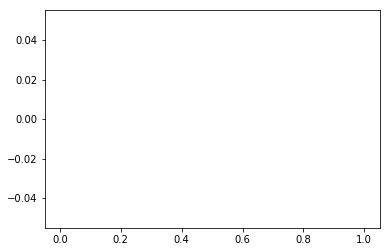

In [43]:
pylab.figure()
pylab.hist(Prec_classes[0][~np.isnan(Prec_classes[0])])
pylab.show()

In [45]:
np.nanmax(Prec_classes[3])

/home/ddesantis/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


nan

# The following is to test to see if I am getting any mixed classes

In [164]:
ex = np.stack(Prec_classes, axis=0)
ex.shape

(7, 200, 200)

In [165]:
ex[:,3,100]

array([0., 0., 0., 0., 0., 0., 0.])

In [166]:
ex2 = np.sum(ex,axis=0)

In [167]:
np.max(ex2)

14.0

In [169]:
np.histogram(ex2, bins=21)

(array([ 2580,     0,     0,     0,     0,     0,     0, 37160,     0,
            0,     0,     0,     0,     0,    68,     0,     0,     0,
            0,     0,   192]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]))

In [141]:
#Some of the class 2 and class 3 get pushed down to class 1 or 0 at some resolution